In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Kladi Tutorial

This tutorial will cover the main steps of the analysis from my presentation:

0. Data loading and QC
1. scIPM modeling
2. Pseudotime inference
3. RP modeling
4. Driver TF Analaysis (covISD)

Right now, I'm calling it <i>Kladi</i> which means "branch" in Greek. I want to rename scIPM too but haven't come up with anything yet.

# 0. Data loading and QC

I've aready run QC and joined cells from the Share-seq dataset, but like we discussed, best data format is two anndata objects with expression and accessibility, and they must have identical cell axes by the time you create your joint representation

In [4]:
import scanpy as sc
import os
import numpy as np
import anndata
import glob
import logging
import seaborn as sns
sns.set(style = 'ticks')

In [ ]:
atac_data = anndata.read_h5ad('data/shareseq/2021-02-01_atac_data.h5ad')

In [49]:
gex_data = anndata.read_h5ad('./data/shareseq/2021-05-05_just_raw_counts.h5ad')
gex_data.var.index = gex_data.var.index.str.upper()
gex_data=gex_data[:,~gex_data.var.index.duplicated()]

# 1a. scIPM expression modeling

First, we start by learning a latent represetnation of our data using scIPM, and we need to tune the hyperparameters. There are four major parameters that may be changed, from least to most important:

1. *dropout*: regularization parameter for encoder and decoder. Default of 0.2 appears to work well enought. If you experience "Node collapse", where multiple topics start to look the same or don't seem to describe a cohesive set of cells, increase this parameter.

2. *initial_counts*: related to the dirichlet prior, default of 10 leads to the discovery of really sharp, sparse latent representations. The genes that will be highly activated for these types of topics will be genes whose expression changes rapidly with the rise of new modules. These are usually the most interesting. Increasing to 20+ will lead to the discovery of more gradual trends.

3. *num_modules*: number of modules to extract from data. Should be carefully chosen. Too few and your imputations will not make sense and you'll miss interesting trends. Too many and eventually the model stops finding useful topics. It will still discover the major trends. Too many is probably better than too few.

**Expr model only:**

which genes to use for 1) latent variable features, 2) imputations.

When imputing data for later use in covISD and other downstream analysis, it's nice to know expression trends for genes that are not considered "highly variable", since basally-expressed TFs can still have intersting and cell-type specific effects. The first parameter of the expression model, "genes" should just be a list of all genes you want to impute, chosen by a tolerant mean_expression threshold.

The optional "highly_variable" parameter takes a boolean mask of the same length as your genelist. Genes marked with ``False`` will not be used as features for learning the latent variables for each cell. Excluding genes that are basally-expressed from the encoder features may help the model learn modules that are more fidelitous to the variability in the system rather than slow/basal trends.

Trying to set attribute `.var` of view, copying.


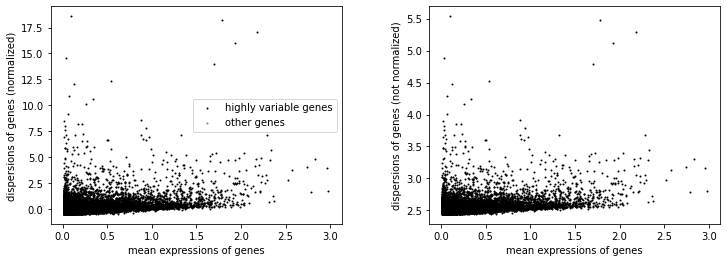

AnnData object with n_obs × n_vars = 34768 × 12180
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'neighbors', 'pca', 'log1p', 'hvg'
    layers: 'counts'

In [50]:
sc.pp.filter_genes(gex_data, min_cells=15) #filter very lowly-expressed genes
gex_data.layers['counts'] = gex_data.X #save the raw data for scIPM.

sc.pp.normalize_total(gex_data, target_sum=1e4) #naive normalization
sc.pp.log1p(gex_data) 
sc.pp.highly_variable_genes(gex_data, min_disp=-0.5, n_bins=2,
                max_mean=3, subset=True) #set min_disp to -0.5 to catch all genes worth imputing
                                         #with subset=True, returns adata with nonvariable genes filtered out

sc.pl.highly_variable_genes(gex_data)

gex_data

Next, we can set a higher dispersion threshold for encoder features so we capture latent variable that track with dispersed genes, and to avoid training a high-dimensional encoder.

In [58]:
sc.pp.highly_variable_genes(gex_data) #use scanpy's defaults are good

gex_data.var.highly_variable.sum() #leaves use with 1800 genes to use as features, and 12000 genes to impute.
                                   #since the latent-variable to imputated expression relationship is linear, this
                                   #model won't have too many parameters

1813

In [59]:
# import the expression model
from kladi.matrix_models.expression_model import ExpressionModel

Next, we need to optimize the ``num_modules`` parameter. For this we use the ExpressionModels ``param_search`` function. This function takes args to specify a model, and an array of module nums to try in the ``num_modules`` argument.

It returns the test loss for each modeling condition. 
I may integrate this with the sklearn model selection construct in the future. 

**Use a GPU to train scIPM, otherwise it'll take forever.** If you're sucessfully using a GPU, the "Using CUDA" log output will be ``True``.

In [60]:
help(ExpressionModel.param_search)

Help on method param_search in module kladi.matrix_models.expression_model:

param_search(*, counts, genes, num_modules, highly_variable=None, initial_counts=10, dropout=0.2, hidden=128, use_cuda=True, num_epochs=100, batch_size=32, learning_rate=0.001, eval_every=1, test_proportion=0.05) method of builtins.type instance



In [ ]:
counts = np.array(gex_data.layers['counts'].todense())# convert to dense matrix
test_modulenums = [6,10,16,24,30,36] 

test_loss = ExpressionModel.param_search(
        counts = counts, # count matrix (raw)
        genes = gex_data.var_names,  #names of genes/count columns, used for enrichment analysis
        num_modules= test_modulenums, #list of number of modules to try
        highly_variable=gex_data.var.highly_variable.values #mask over genes. Genes marked with True are used as encoder features
)

In [ ]:
sns.scatterplot(x = test_modulenums, y = test_loss)

Once we've found the best number of modules, we can train the "official" model of our expression data.

In [ ]:
expr_model = ExpressionModel(gex_data.var_names, 
                             highly_variable=gex_data.var.highly_variable.values, 
                             num_modules=24).fit(counts)

At this point, saving the model is probably a good idea.

In [ ]:
expr_model.save('expr_model.pth') #save

to reload the model, instantiate a scIPM object using the same parameters:
```
expr_model = ExpressionModel(gex_data.var_names, 
                             highly_variable=gex_data.var.highly_variable.values, 
                             num_modules=24)
expr_model.load('expr_model.pth')
```

After training the model, we can get our topics and imputations

In [ ]:
gex_data.obsm['rna_topics'] = expr_model.predict(counts) #get latent vars
gex_data.layers['imputed'] = expr_model.impute(gex_data.obsm['rna_topics']) #use latent vars to impute

And we're done with expression modeling for now. Moving on to accessibility modeling.

# 1b. Accessibility Modeling

Training the accessibility model takes much much longer than the expression model, so it's best to use the same parameters optimized in the expression model.

Usually, we don't need to filter out any peaks from ATAC-seq peakcount matrices, since peaks are defined by having met a certain threshold of cells/fragments to be recognized in the first place. Filtering rare peaks makes it more difficult to learn modules for small populations.

The API is the same as the expression model, except that ``highly_available`` is not available, and instead of genes, we pass peaks (used for TF enrichment). The format for peaks is [[chr, start, end], ... ]:
```
[['chr9', 123461850, 123462150],
 ['chr1', 56782095, 56782395],
 ...
 ['chr16', 18533123, 18533423]]
```
They don't have to be sorted.

In [ ]:
atac_model = AccessibilityModel(atac_data.var[['chr','start','end']].values.tolist(), num_modules=24)\
    .fit(atac_data.X) # pass raw peakcounts as sparse matrix

In [ ]:
atac_model.save('atac_model.pth')

To load:
```
atac_model = AccessibilityModel(atac_data.var[['chr','start','end']].values.tolist(), num_modules=24)
atac_model.load('atac_model.pth')
```

We can get our atac latent variables, but we won't impute peaks since this will create a #cells x #peaks dense matrix which we really don't need in-memory for the analysis.

In [ ]:
atac_data.obsm['atac_topics'] = atac_data.predict(atac_data.X)

So that concludes the construction of our latent variable understanding of gene and peak modules in the data. Next step is to use these modules to make a joint low-dimensional representation of the data, then identify our intersting differentiation system.

# 2a. Joint representation + system identification

In [ ]:
from kladi.matrix_models.ilr import ilr # the ILR (isometric logratio) transformation transforms compositional-space
                                        # latent variable to euclidean space

In [ ]:
gex_data.obsm['joint_modules'] = np.hstack([ #hstack pastes the two matrices together. MAKE SURE CELLS ARE ALIGNED!!
    1.5 * ilr(gex_data.obsm['rna_topics']), #I scale the RNA representation by 1.5
    ilr(atac_data.obsm['atac_topics'])
])